In [ ]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_Matern_0.5.xlsx")

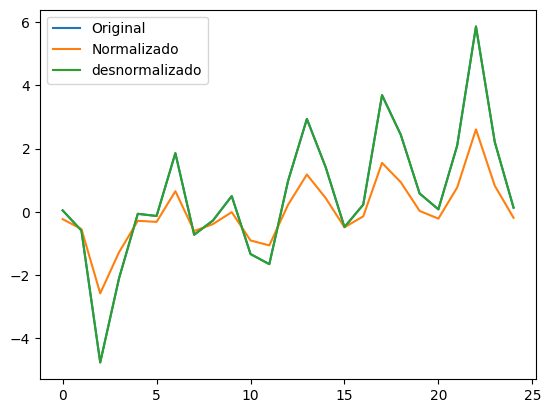

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:12:38.148049: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:12:38.154880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:12:38.174540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753135958.204896  872404 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753135958.213233  872404 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753135958.255846  872404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.783723,0.550000,0.495622,0.767353,0.719899,3.009152,1.804132,1.039206,2.117395,0.848468,0.705496,0.861831,34.657289,71.621873
model_1_2_8,0.783015,0.549330,0.495044,0.766531,0.722258,3.013631,1.806198,1.042879,2.116871,0.849858,0.704530,0.863242,34.650745,71.615328
model_1_2_7,0.782291,0.548572,0.494414,0.765688,0.724666,3.018703,1.808453,1.046644,2.116340,0.851273,0.703545,0.864680,34.644088,71.608672
model_1_2_6,0.780802,0.545277,0.493687,0.763942,0.729625,3.040733,1.811053,1.054441,2.115254,0.854181,0.701517,0.867633,34.630450,71.595034
model_1_2_5,0.776818,0.541088,0.489750,0.759228,0.742886,3.068745,1.825135,1.075497,2.112336,0.861908,0.696092,0.875482,34.594427,71.559010
model_1_2_4,0.770560,0.534836,0.484284,0.751760,0.763713,3.110553,1.844687,1.108857,2.107654,0.873907,0.687572,0.887670,34.539126,71.503710
model_1_2_3,0.769596,0.533921,0.483476,0.750606,0.766922,3.116670,1.847578,1.114012,2.106921,0.875741,0.686259,0.889533,34.530740,71.495324
model_1_2_2,0.767612,0.531844,0.481644,0.748229,0.773529,3.130565,1.854131,1.124628,2.105402,0.879505,0.683556,0.893356,34.513585,71.478168
model_1_2_1,0.762301,0.525154,0.477329,0.741869,0.791205,3.175299,1.869565,1.153042,2.101289,0.889497,0.676325,0.903506,34.468395,71.432979
model_1_2_0,0.751231,0.517406,0.472181,0.728619,0.828054,3.227109,1.887978,1.212224,2.092731,0.909975,0.661250,0.924306,34.377353,71.341936


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  28
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.811281,0.606931,0.473117,0.276683,0.628172,2.628456,1.884630,1.264407,2.107195,0.792573,0.743020,0.805055,34.929883,71.894466
model_1_3_7,0.811038,0.606786,0.473826,0.277857,0.628980,2.629422,1.882093,1.262354,2.111904,0.793083,0.742690,0.805573,34.927311,71.891895
model_1_3_8,0.811202,0.606681,0.473325,0.277074,0.628433,2.630127,1.883887,1.263724,2.108743,0.792738,0.742914,0.805222,34.929052,71.893636
model_1_3_6,0.810179,0.603839,0.475889,0.281430,0.631840,2.649129,1.874716,1.256109,2.127062,0.794884,0.741520,0.807402,34.918239,71.882822
model_1_3_5,0.806284,0.597126,0.482745,0.291622,0.644802,2.694017,1.850192,1.238292,2.181507,0.802996,0.736217,0.815642,34.877623,71.842207
model_1_3_4,0.805455,0.595151,0.483917,0.293097,0.647564,2.707224,1.845999,1.235715,2.191036,0.804714,0.735087,0.817387,34.869075,71.833659
model_1_3_3,0.799207,0.584892,0.491413,0.300884,0.668361,2.775831,1.819187,1.222101,2.254323,0.817533,0.726579,0.830409,34.805854,71.770438
model_1_3_2,0.795799,0.561822,0.492292,0.301954,0.679704,2.930101,1.816043,1.220231,2.238244,0.824442,0.721939,0.837426,34.772195,71.736778
model_1_3_1,0.794674,0.560213,0.492357,0.302926,0.683449,2.940857,1.815811,1.218531,2.231798,0.826710,0.720407,0.839729,34.761207,71.725791
model_1_3_0,0.792328,0.557688,0.492837,0.305645,0.691258,2.957744,1.814092,1.213779,2.216108,0.831419,0.717212,0.844513,34.738484,71.703068


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.812724,0.606711,0.445991,0.813631,0.623367,2.629926,1.981659,0.891933,2.045958,0.789536,0.744986,0.801970,34.945240,71.909824
model_1_4_2,0.813260,0.603883,0.421120,0.796424,0.621583,2.648836,2.070621,0.974280,1.973982,0.788405,0.745716,0.800822,34.950973,71.915557
model_1_4_3,0.813352,0.603750,0.418261,0.792661,0.621278,2.649724,2.080847,0.992288,1.959669,0.788212,0.745841,0.800626,34.951953,71.916536
model_1_4_4,0.813445,0.603540,0.416762,0.790351,0.620968,2.651131,2.086209,1.003343,1.950406,0.788015,0.745968,0.800425,34.952953,71.917536
model_1_4_5,0.813504,0.603452,0.416118,0.789266,0.620772,2.651721,2.088511,1.008539,1.945846,0.787891,0.746048,0.800299,34.953584,71.918167
model_1_4_1,0.813219,0.603363,0.423585,0.799079,0.621721,2.652312,2.061803,0.961572,1.983852,0.788493,0.745659,0.800911,34.950528,71.915112
model_1_4_6,0.814309,0.602777,0.412477,0.782440,0.618092,2.656230,2.101537,1.041207,1.910668,0.786188,0.747144,0.798570,34.962237,71.926821
model_1_4_7,0.814450,0.602664,0.412148,0.781816,0.617623,2.656985,2.102713,1.044192,1.906350,0.785890,0.747336,0.798267,34.963755,71.928338
model_1_4_8,0.814599,0.602613,0.411856,0.781241,0.617126,2.657326,2.103759,1.046946,1.902040,0.785573,0.747539,0.797945,34.965366,71.929949
model_1_4_9,0.814920,0.602552,0.411317,0.780226,0.616056,2.657733,2.105684,1.051801,1.893480,0.784893,0.747977,0.797254,34.968834,71.933418


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.818538,0.615034,0.450704,0.854137,0.604015,2.574266,1.964800,0.506874,1.894802,0.777184,0.752903,0.789424,35.008312,71.972896
model_1_5_8,0.817778,0.611126,0.440364,0.854853,0.606546,2.600401,2.001786,0.504384,1.895747,0.778811,0.751867,0.791076,34.999950,71.964533
model_1_5_7,0.817584,0.610241,0.436024,0.855046,0.607192,2.606321,2.017308,0.503716,1.895886,0.779225,0.751603,0.791497,34.997821,71.962405
model_1_5_6,0.817195,0.607504,0.421993,0.855464,0.608486,2.624621,2.067498,0.502262,1.896169,0.780055,0.751074,0.792340,34.993563,71.958147
model_1_5_5,0.817009,0.605297,0.413397,0.855717,0.609103,2.639382,2.098244,0.501385,1.896222,0.780451,0.750821,0.792742,34.991535,71.956118
model_1_5_4,0.816656,0.604324,0.411450,0.856301,0.610280,2.645887,2.105208,0.499355,1.895896,0.781204,0.750340,0.793507,34.987676,71.952259
model_1_5_2,0.816305,0.603914,0.411599,0.856936,0.611447,2.648630,2.104677,0.497148,1.895224,0.781951,0.749862,0.794266,34.983853,71.948437
model_1_5_3,0.816480,0.603802,0.410687,0.856611,0.610866,2.649380,2.107937,0.498278,1.895610,0.781579,0.750100,0.793889,34.985754,71.950338
model_1_5_1,0.816130,0.603657,0.411563,0.857270,0.612031,2.650349,2.104804,0.495988,1.894759,0.782324,0.749624,0.794645,34.981946,71.946529
model_1_5_0,0.815091,0.603150,0.413566,0.859514,0.615489,2.653735,2.097639,0.488189,1.892661,0.784531,0.748209,0.796887,34.970677,71.935260


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.818109,0.609938,0.450904,0.705644,0.605444,2.608346,1.964086,1.111386,1.966600,0.778103,0.752318,0.790357,35.003585,71.968169
model_1_6_1,0.818289,0.609620,0.447036,0.704631,0.604843,2.610476,1.977920,1.115213,1.970722,0.777716,0.752564,0.789965,35.005574,71.970157
model_1_6_9,0.815930,0.608747,0.431484,0.644500,0.612697,2.616312,2.033548,1.342246,2.246776,0.782750,0.749351,0.795077,34.979770,71.944353
model_1_6_2,0.818764,0.608151,0.436793,0.695304,0.603261,2.620294,2.014560,1.150425,2.018313,0.776699,0.753211,0.788931,35.010810,71.975393
model_1_6_8,0.818227,0.606642,0.434167,0.671121,0.605050,2.630387,2.023953,1.241733,2.131204,0.777849,0.752479,0.790100,35.004889,71.969473
model_1_6_7,0.818267,0.606612,0.434220,0.671813,0.604917,2.630588,2.023762,1.239122,2.128116,0.777764,0.752534,0.790013,35.005327,71.969910
model_1_6_6,0.818517,0.606410,0.434642,0.676780,0.604086,2.631940,2.022254,1.220368,2.105658,0.777229,0.752874,0.789470,35.008079,71.972663
model_1_6_5,0.818682,0.606188,0.435162,0.681205,0.603537,2.633420,2.020392,1.203659,2.085811,0.776876,0.753098,0.789111,35.009896,71.974480
model_1_6_4,0.818743,0.606084,0.435371,0.683473,0.603333,2.634118,2.019647,1.195097,2.075413,0.776745,0.753182,0.788978,35.010573,71.975156
model_1_6_3,0.818799,0.606010,0.435733,0.686550,0.603146,2.634611,2.018350,1.183477,2.061040,0.776625,0.753258,0.788856,35.011191,71.975774


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.815448,0.623837,0.464635,0.814163,0.614302,2.515401,1.914970,0.666854,2.158671,0.783774,0.748695,0.796118,34.974538,71.939122
model_1_7_8,0.815977,0.621969,0.460874,0.821520,0.612538,2.527898,1.928423,0.640454,2.170323,0.782648,0.749416,0.794974,34.980288,71.944871
model_1_7_7,0.816036,0.621691,0.460346,0.822459,0.612344,2.529752,1.930310,0.637086,2.171847,0.782524,0.749495,0.794848,34.980921,71.945504
model_1_7_6,0.816092,0.621403,0.459809,0.823401,0.612157,2.531680,1.932230,0.633705,2.173388,0.782405,0.749572,0.794727,34.981531,71.946115
model_1_7_5,0.816621,0.617251,0.453111,0.836966,0.610395,2.559444,1.956191,0.585028,2.197633,0.781278,0.750293,0.793582,34.987298,71.951882
model_1_7_4,0.816631,0.617137,0.453721,0.837936,0.610362,2.560208,1.954007,0.581549,2.199574,0.781257,0.750306,0.793561,34.987405,71.951989
model_1_7_3,0.816651,0.616528,0.451654,0.838956,0.610296,2.564279,1.961400,0.577886,2.201444,0.781214,0.750333,0.793518,34.987623,71.952206
model_1_7_2,0.816670,0.615317,0.448811,0.841963,0.610232,2.572379,1.971571,0.567097,2.207272,0.781174,0.750359,0.793476,34.987831,71.952415
model_1_7_1,0.816669,0.614932,0.447992,0.842968,0.610237,2.574950,1.974501,0.563490,2.209258,0.781177,0.750357,0.793480,34.987814,71.952398
model_1_7_0,0.816664,0.614288,0.445992,0.843979,0.610253,2.579258,1.981654,0.559864,2.211260,0.781187,0.750351,0.793490,34.987765,71.952348


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.815709,0.623529,0.464961,0.742225,0.613433,2.517466,1.913805,0.662951,2.160405,0.783220,0.749050,0.795555,34.977369,71.941952
model_1_8_1,0.815789,0.623429,0.465060,0.741738,0.613166,2.518132,1.913451,0.664202,2.160969,0.783049,0.749159,0.795381,34.978239,71.942823
model_1_8_2,0.815866,0.623340,0.465175,0.741250,0.612910,2.518727,1.913036,0.665457,2.161524,0.782886,0.749264,0.795215,34.979075,71.943658
model_1_8_3,0.815940,0.623242,0.465272,0.740762,0.612664,2.519384,1.912692,0.666714,2.162074,0.782729,0.749364,0.795056,34.979877,71.944461
model_1_8_4,0.816010,0.623163,0.465450,0.740272,0.612428,2.519908,1.912055,0.667972,2.162616,0.782578,0.749461,0.794903,34.980646,71.945230
model_1_8_5,0.816479,0.622353,0.465781,0.736358,0.610869,2.525327,1.910869,0.678039,2.166719,0.781581,0.750099,0.793890,34.985746,71.950330
model_1_8_6,0.817099,0.620612,0.467761,0.726016,0.608805,2.536969,1.903789,0.704637,2.176173,0.780259,0.750943,0.792548,34.992516,71.957099
model_1_8_7,0.817110,0.620542,0.467821,0.725569,0.608768,2.537435,1.903573,0.705786,2.176588,0.780236,0.750958,0.792524,34.992637,71.957221
model_1_8_8,0.817120,0.620454,0.467713,0.725125,0.608734,2.538026,1.903960,0.706929,2.176995,0.780214,0.750972,0.792502,34.992747,71.957331
model_1_8_9,0.817160,0.620045,0.470756,0.721237,0.608603,2.540762,1.893074,0.716928,2.180596,0.780130,0.751026,0.792416,34.993180,71.957763


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_4,0.816737,0.620648,0.465912,0.696328,0.610008,2.536729,1.910403,0.978325,2.208694,0.781030,0.750451,0.793331,34.988566,71.953150
model_1_9_3,0.817074,0.620234,0.468229,0.712754,0.608887,2.539497,1.902113,0.925405,2.193850,0.780312,0.750910,0.792601,34.992245,71.956829
model_1_9_2,0.817098,0.620168,0.468324,0.714683,0.608807,2.539936,1.901774,0.919192,2.192074,0.780261,0.750942,0.792549,34.992507,71.957090
model_1_9_1,0.817119,0.620074,0.468454,0.716631,0.608739,2.540566,1.901310,0.912916,2.190260,0.780217,0.750970,0.792505,34.992732,71.957315
model_1_9_0,0.817163,0.619827,0.468898,0.724611,0.608592,2.542222,1.899721,0.887207,2.182591,0.780123,0.751030,0.792409,34.993216,71.957799
model_1_9_8,0.817323,0.603078,0.458269,0.675950,0.608059,2.654218,1.937740,1.043974,2.234726,0.779781,0.751248,0.792062,34.994967,71.959551
model_1_9_6,0.817391,0.602970,0.458746,0.678359,0.607834,2.654938,1.936033,1.036216,2.231908,0.779637,0.751340,0.791916,34.995706,71.960290
model_1_9_5,0.817421,0.602965,0.459074,0.679576,0.607734,2.654978,1.934861,1.032292,2.230496,0.779573,0.751382,0.791850,34.996038,71.960621
model_1_9_7,0.817358,0.602958,0.458401,0.677150,0.607943,2.655024,1.937267,1.040109,2.233308,0.779707,0.751296,0.791986,34.995349,71.959933
model_1_9_9,0.817114,0.602823,0.456550,0.670071,0.608754,2.655927,1.943889,1.062916,2.242038,0.780227,0.750964,0.792515,34.992681,71.957265


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.815125,0.608716,0.483766,0.852981,0.615375,2.616516,1.846539,0.972458,2.297681,0.784458,0.748255,0.796813,34.971047,71.935630
model_1_10_8,0.815202,0.608658,0.483415,0.853293,0.615119,2.616904,1.847793,0.970397,2.296601,0.784295,0.748360,0.796647,34.971880,71.936464
model_1_10_7,0.815279,0.608596,0.483057,0.853606,0.614864,2.617323,1.849075,0.968327,2.295506,0.784133,0.748464,0.796482,34.972708,71.937292
model_1_10_6,0.815505,0.608396,0.481892,0.854553,0.614111,2.618658,1.853242,0.962062,2.292155,0.783652,0.748772,0.795994,34.975159,71.939742
model_1_10_5,0.816076,0.607770,0.478419,0.857138,0.612209,2.622846,1.865665,0.944961,2.282711,0.782438,0.749551,0.794760,34.981365,71.945948
model_1_10_4,0.816144,0.607669,0.478197,0.857467,0.611985,2.623518,1.866461,0.942789,2.281481,0.782294,0.749642,0.794615,34.982096,71.946680
model_1_10_3,0.816210,0.607573,0.477707,0.857796,0.611764,2.624164,1.868211,0.940608,2.280242,0.782154,0.749733,0.794472,34.982816,71.947400
model_1_10_2,0.816462,0.607126,0.475610,0.859124,0.610924,2.627152,1.875712,0.931824,2.275183,0.781617,0.750076,0.793926,34.985564,71.950148
model_1_10_1,0.816690,0.606658,0.473362,0.860462,0.610165,2.630279,1.883753,0.922974,2.269971,0.781131,0.750387,0.793433,34.988051,71.952634
model_1_10_0,0.816743,0.606546,0.472776,0.860798,0.609991,2.631027,1.885848,0.920756,2.268647,0.781019,0.750458,0.793319,34.988623,71.953207


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.815196,0.608639,0.483779,0.791222,0.615139,2.617036,1.846494,0.461018,2.294622,0.784308,0.748352,0.796660,34.971814,71.936398
model_1_11_1,0.815819,0.607893,0.483973,0.784668,0.613066,2.622021,1.845800,0.475490,2.257579,0.782985,0.749200,0.795317,34.978565,71.943148
model_1_11_2,0.816033,0.607151,0.484339,0.776270,0.612354,2.626983,1.844490,0.494034,2.220155,0.782530,0.749491,0.794855,34.980890,71.945473
model_1_11_3,0.816034,0.607033,0.484409,0.774593,0.612349,2.627775,1.844238,0.497737,2.213266,0.782527,0.749493,0.794852,34.980905,71.945489
model_1_11_4,0.816032,0.606990,0.484437,0.774038,0.612355,2.628058,1.844139,0.498962,2.211043,0.782531,0.749491,0.794855,34.980886,71.945470
model_1_11_5,0.816030,0.606928,0.484469,0.773486,0.612364,2.628473,1.844025,0.500182,2.208860,0.782537,0.749487,0.794861,34.980857,71.945440
model_1_11_6,0.816016,0.606800,0.484560,0.771845,0.612409,2.629331,1.843699,0.503805,2.202433,0.782566,0.749469,0.794890,34.980709,71.945293
model_1_11_7,0.815969,0.606578,0.484746,0.768656,0.612567,2.630813,1.843035,0.510847,2.190092,0.782666,0.749404,0.794993,34.980195,71.944779
model_1_11_8,0.815948,0.606490,0.484815,0.767624,0.612635,2.631401,1.842789,0.513125,2.186119,0.782710,0.749376,0.795037,34.979972,71.944555
model_1_11_9,0.815914,0.606355,0.484934,0.766109,0.612749,2.632303,1.842360,0.516472,2.180291,0.782783,0.749330,0.795111,34.979600,71.944183


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  38
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.821983,0.618047,0.508162,0.651952,0.592548,2.554118,1.759277,1.082601,2.346335,0.769771,0.757594,0.781895,35.046647,72.011230
model_1_12_8,0.821962,0.613459,0.507877,0.652054,0.592618,2.584801,1.760296,1.082285,2.345747,0.769817,0.757565,0.781941,35.046411,72.010995
model_1_12_7,0.821941,0.613381,0.507590,0.652159,0.592689,2.585322,1.761321,1.081957,2.345116,0.769863,0.757536,0.781987,35.046172,72.010755
model_1_12_6,0.821897,0.613359,0.507012,0.652382,0.592835,2.585472,1.763389,1.081264,2.343724,0.769958,0.757476,0.782084,35.045678,72.010262
model_1_12_5,0.821753,0.612868,0.505242,0.653153,0.593312,2.588755,1.769720,1.078867,2.338478,0.770267,0.757281,0.782398,35.044070,72.008653
model_1_12_2,0.820222,0.611863,0.494401,0.660879,0.598408,2.595476,1.808500,1.054834,2.291465,0.773569,0.755196,0.785752,35.026963,71.991547
model_1_12_4,0.821318,0.611472,0.500937,0.655597,0.594761,2.598089,1.785120,1.071265,2.323904,0.771207,0.756689,0.783353,35.039193,72.003777
model_1_12_3,0.821280,0.611351,0.500623,0.655807,0.594888,2.598901,1.786243,1.070610,2.322655,0.771290,0.756636,0.783437,35.038763,72.003347
model_1_12_1,0.819776,0.607276,0.492665,0.662608,0.599893,2.626149,1.814709,1.049457,2.279071,0.774528,0.754589,0.786726,35.022007,71.986590
model_1_12_0,0.819191,0.606011,0.490801,0.664683,0.601840,2.634609,1.821376,1.043001,2.264605,0.775783,0.753793,0.788001,35.015528,71.980111


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.820404,0.616315,0.515429,0.816426,0.597804,2.565701,1.733283,0.889429,2.328137,0.773178,0.755444,0.785354,35.028986,71.993569
model_1_13_6,0.821902,0.616122,0.531165,0.812125,0.592818,2.566996,1.676995,0.910267,2.277576,0.769947,0.757483,0.782073,35.045736,72.010320
model_1_13_4,0.821631,0.616099,0.528869,0.812536,0.593720,2.567150,1.685209,0.908278,2.284828,0.770533,0.757114,0.782668,35.042693,72.007277
model_1_13_5,0.821723,0.616081,0.529644,0.812398,0.593414,2.567271,1.682437,0.908945,2.282391,0.770334,0.757240,0.782466,35.043727,72.008310
model_1_13_7,0.821989,0.616048,0.531917,0.811989,0.592529,2.567488,1.674306,0.910923,2.275198,0.769759,0.757602,0.781882,35.046712,72.011296
model_1_13_9,0.822152,0.615099,0.533530,0.811702,0.591985,2.573835,1.668536,0.912314,2.270506,0.769406,0.757824,0.781523,35.048547,72.013131
model_1_13_8,0.822073,0.615089,0.532734,0.811851,0.592248,2.573903,1.671385,0.911593,2.272841,0.769577,0.757716,0.781697,35.047658,72.012242
model_1_13_3,0.820953,0.613494,0.524733,0.813070,0.595976,2.584568,1.700002,0.905689,2.300595,0.771995,0.756192,0.784153,35.035111,71.999694
model_1_13_2,0.820700,0.611966,0.524197,0.812701,0.596817,2.594784,1.701921,0.907477,2.303355,0.772539,0.755847,0.784706,35.032289,71.996873
model_1_13_1,0.820026,0.611629,0.523022,0.811402,0.599063,2.597041,1.706123,0.913770,2.308981,0.773992,0.754928,0.786181,35.024776,71.989360


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_5,0.823736,0.621550,0.532282,0.482792,0.586714,2.530696,1.673002,0.606325,2.230712,0.765972,0.759981,0.778036,35.066437,72.031020
model_1_14_4,0.823779,0.621505,0.532293,0.484519,0.586571,2.531001,1.672961,0.604299,2.230177,0.765879,0.760039,0.777941,35.066924,72.031508
model_1_14_9,0.822951,0.621254,0.532611,0.403559,0.589325,2.532674,1.671824,0.699209,2.197211,0.767675,0.758912,0.779765,35.057556,72.022140
model_1_14_8,0.822935,0.621242,0.532590,0.404018,0.589379,2.532755,1.671899,0.698671,2.200106,0.767710,0.758890,0.779801,35.057373,72.021957
model_1_14_7,0.822843,0.621000,0.532355,0.410824,0.589686,2.534375,1.672738,0.690693,2.231606,0.767910,0.758765,0.780004,35.056329,72.020913
model_1_14_6,0.821454,0.620586,0.532293,0.417255,0.594310,2.537146,1.672960,0.683153,2.259643,0.770915,0.756873,0.783056,35.040708,72.005291
model_1_14_3,0.824318,0.620562,0.532981,0.514741,0.584776,2.537301,1.670499,0.568870,2.230279,0.764707,0.760773,0.776750,35.073051,72.037635
model_1_14_2,0.824338,0.620540,0.533064,0.516812,0.584709,2.537449,1.670202,0.566442,2.231190,0.764663,0.760800,0.776706,35.073281,72.037864
model_1_14_1,0.824356,0.620453,0.533153,0.518906,0.584650,2.538031,1.669886,0.563988,2.232337,0.764624,0.760825,0.776666,35.073483,72.038066
model_1_14_0,0.822243,0.619288,0.533753,0.534662,0.591684,2.545824,1.667739,0.545516,2.261884,0.769210,0.757947,0.781324,35.049566,72.014149


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99m

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_9,0.940041,0.751218,0.790047,0.901787,0.199580,1.663609,0.750988,0.381937,0.853098,0.446744,0.918353,0.453780,37.223077,74.187660
model_2_0_8,0.940203,0.750581,0.791306,0.903017,0.199042,1.667869,0.746488,0.377154,0.874184,0.446141,0.918574,0.453168,37.228478,74.193062
model_2_0_7,0.940449,0.748900,0.793206,0.905780,0.198221,1.679110,0.739692,0.366409,0.920555,0.445220,0.918910,0.452232,37.236748,74.201331
model_2_0_6,0.940334,0.744678,0.795902,0.911032,0.198604,1.707341,0.730046,0.345986,1.021820,0.445650,0.918753,0.452669,37.232885,74.197469
model_2_0_5,0.937651,0.734077,0.798417,0.919107,0.207535,1.778229,0.721052,0.314581,1.222888,0.455560,0.915099,0.462734,37.144913,74.109497
model_2_0_4,0.929759,0.711112,0.799085,0.925220,0.233804,1.931798,0.718662,0.290810,1.415356,0.483532,0.904353,0.491147,36.906548,73.871132
model_2_0_3,0.900688,0.656755,0.785221,0.901770,0.330572,2.295282,0.768250,0.382003,1.261661,0.574954,0.864766,0.584009,36.213863,73.178446
model_2_0_2,0.896347,0.649284,0.780674,0.898115,0.345019,2.345240,0.784515,0.396216,1.173562,0.587383,0.858856,0.596634,36.128312,73.092896
model_2_0_1,0.889319,0.639133,0.773523,0.894088,0.368414,2.413121,0.810097,0.411878,1.129659,0.606971,0.849285,0.616530,35.997099,72.961682
model_2_0_0,0.879612,0.626513,0.763891,0.888603,0.400724,2.497512,0.844548,0.433208,1.105528,0.633028,0.836067,0.642997,35.828964,72.793547


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  31
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_0,0.942320,0.747677,0.791857,0.976262,0.191993,1.687288,0.744517,0.216322,0.832911,0.438170,0.921458,0.445070,37.300597,74.265181
model_2_1_1,0.941691,0.721692,0.787643,0.958526,0.194087,1.861045,0.759588,0.377945,0.854930,0.440553,0.920601,0.447491,37.278897,74.243480
model_2_1_9,0.944663,0.716024,0.776251,0.948862,0.184194,1.898949,0.800335,0.466010,0.634982,0.429178,0.924648,0.435937,37.383533,74.348117
model_2_1_8,0.944607,0.716001,0.776251,0.948784,0.184381,1.899104,0.800338,0.466722,0.635711,0.429396,0.924571,0.436159,37.381499,74.346083
model_2_1_7,0.944548,0.715975,0.776243,0.948703,0.184578,1.899275,0.800367,0.467455,0.636521,0.429625,0.924491,0.436392,37.379366,74.343950
model_2_1_6,0.944486,0.715948,0.776226,0.948620,0.184785,1.899460,0.800427,0.468211,0.637423,0.429866,0.924406,0.436636,37.377127,74.341711
model_2_1_2,0.941018,0.713570,0.782549,0.953438,0.196327,1.915358,0.777811,0.424312,0.714789,0.443088,0.919684,0.450066,37.255950,74.220533
model_2_1_5,0.943913,0.712696,0.774369,0.949725,0.186691,1.921204,0.807070,0.458149,0.614454,0.432077,0.923626,0.438882,37.356601,74.321185
model_2_1_3,0.940432,0.712361,0.782591,0.952005,0.198279,1.923440,0.777658,0.437371,0.761207,0.445285,0.918886,0.452298,37.236163,74.200747
model_2_1_4,0.943203,0.711100,0.773932,0.950106,0.189053,1.931873,0.808631,0.454675,0.604458,0.434802,0.922660,0.441650,37.331456,74.296040


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.951723,0.739217,0.773186,0.953216,0.160694,1.743854,0.811299,0.133322,0.788308,0.400867,0.934261,0.407180,37.656500,74.621084
model_2_2_8,0.951738,0.738518,0.773289,0.955023,0.160645,1.748532,0.810932,0.128174,0.790085,0.400805,0.934282,0.407118,37.657117,74.621701
model_2_2_7,0.951707,0.737717,0.773313,0.956923,0.160749,1.753890,0.810846,0.122760,0.791867,0.400935,0.934239,0.407249,37.655825,74.620408
model_2_2_6,0.951615,0.736797,0.773237,0.958905,0.161056,1.760038,0.811118,0.117111,0.793567,0.401318,0.934113,0.407638,37.652006,74.616589
model_2_2_5,0.951443,0.735741,0.773035,0.960951,0.161628,1.767101,0.811839,0.111281,0.795042,0.402030,0.933879,0.408362,37.644911,74.609495
model_2_2_4,0.951168,0.734525,0.772681,0.963032,0.162541,1.775234,0.813108,0.105351,0.796054,0.403163,0.933506,0.409513,37.633653,74.598237
model_2_2_3,0.950766,0.733121,0.772147,0.965106,0.163881,1.784624,0.815016,0.099439,0.796211,0.404822,0.932958,0.411197,37.617234,74.581818
model_2_2_2,0.950206,0.731493,0.771420,0.967114,0.165744,1.795506,0.817617,0.093716,0.795360,0.407116,0.932196,0.413528,37.594625,74.559208
model_2_2_1,0.949462,0.729598,0.770521,0.968968,0.168220,1.808183,0.820832,0.088434,0.792002,0.410146,0.931183,0.416606,37.564964,74.529547
model_2_2_0,0.948521,0.727370,0.769578,0.970535,0.171354,1.823076,0.824205,0.083968,0.783207,0.413949,0.929901,0.420469,37.528046,74.492630


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  33
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.952542,0.731533,0.767196,0.963678,0.157969,1.795242,0.832725,0.083043,0.615669,0.397453,0.935376,0.403712,37.690716,74.655299
model_2_3_1,0.952539,0.731432,0.767040,0.963622,0.157977,1.795915,0.833286,0.083170,0.616109,0.397464,0.935373,0.403723,37.690607,74.655191
model_2_3_2,0.952537,0.731336,0.766887,0.963572,0.157984,1.796559,0.833833,0.083285,0.616592,0.397472,0.935370,0.403732,37.690521,74.655104
model_2_3_3,0.952536,0.731243,0.766737,0.963527,0.157990,1.797178,0.834367,0.083389,0.617116,0.397480,0.935368,0.403740,37.690446,74.655030
model_2_3_4,0.952534,0.731154,0.766592,0.963485,0.157995,1.797772,0.834888,0.083483,0.617679,0.397486,0.935366,0.403746,37.690385,74.654969
model_2_3_5,0.952533,0.731069,0.766450,0.963448,0.157999,1.798345,0.835396,0.083568,0.618275,0.397490,0.935364,0.403750,37.690339,74.654922
model_2_3_6,0.952532,0.730986,0.766311,0.963414,0.158002,1.798895,0.835892,0.083645,0.618891,0.397494,0.935363,0.403754,37.690301,74.654885
model_2_3_7,0.952532,0.730907,0.766176,0.963383,0.158004,1.799426,0.836376,0.083716,0.619524,0.397497,0.935362,0.403757,37.690273,74.654857
model_2_3_8,0.952531,0.730830,0.766044,0.963355,0.158005,1.799939,0.836848,0.083780,0.620171,0.397499,0.935361,0.403759,37.690253,74.654837
model_2_3_9,0.952531,0.730756,0.765915,0.963330,0.158006,1.800435,0.837309,0.083838,0.620827,0.397500,0.935361,0.403760,37.690240,74.654823


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.951640,0.735480,0.753286,0.957915,0.160973,1.768846,0.882480,0.239102,0.699360,0.401214,0.934147,0.407533,37.653041,74.617624
model_2_4_8,0.951772,0.735259,0.754125,0.958512,0.160530,1.770324,0.879482,0.235706,0.694327,0.400662,0.934328,0.406972,37.658544,74.623128
model_2_4_7,0.951909,0.735004,0.755041,0.959164,0.160076,1.772028,0.876203,0.232002,0.688819,0.400095,0.934514,0.406396,37.664213,74.628797
model_2_4_6,0.952047,0.734710,0.756043,0.959874,0.159617,1.773993,0.872621,0.227970,0.682790,0.399521,0.934702,0.405813,37.669953,74.634536
model_2_4_5,0.952183,0.734370,0.757136,0.960645,0.159165,1.776266,0.868711,0.223592,0.676183,0.398955,0.934887,0.405238,37.675626,74.640210
model_2_4_4,0.952312,0.733976,0.758327,0.961479,0.158735,1.778901,0.864450,0.218852,0.668943,0.398415,0.935063,0.404690,37.681041,74.645624
model_2_4_3,0.952428,0.733518,0.759623,0.962378,0.158348,1.781964,0.859814,0.213741,0.661003,0.397929,0.935221,0.404196,37.685923,74.650506
model_2_4_2,0.952523,0.732984,0.761029,0.963343,0.158033,1.785535,0.854786,0.208260,0.652294,0.397534,0.935350,0.403795,37.689897,74.654480
model_2_4_1,0.952583,0.732359,0.762547,0.964371,0.157832,1.789716,0.849356,0.202423,0.642739,0.397281,0.935432,0.403538,37.692447,74.657030
model_2_4_0,0.952593,0.731624,0.764178,0.965455,0.157798,1.794631,0.843523,0.196263,0.632256,0.397238,0.935446,0.403495,37.692874,74.657458


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.951863,0.735233,0.754132,0.946065,0.160228,1.770500,0.879455,0.165770,0.699440,0.400285,0.934452,0.406589,37.662312,74.626896
model_2_5_1,0.951961,0.734992,0.754911,0.943800,0.159902,1.772111,0.876670,0.172732,0.698499,0.399878,0.934585,0.406176,37.666385,74.630968
model_2_5_2,0.951969,0.734765,0.755631,0.941555,0.159876,1.773627,0.874093,0.179632,0.697163,0.399845,0.934596,0.406142,37.666715,74.631299
model_2_5_3,0.951913,0.734558,0.756301,0.939363,0.160064,1.775014,0.871698,0.186369,0.694989,0.400080,0.934519,0.406381,37.664366,74.628950
model_2_5_4,0.951810,0.734373,0.756927,0.937244,0.160405,1.776250,0.869458,0.192882,0.692137,0.400506,0.934380,0.406813,37.660111,74.624694
model_2_5_5,0.951675,0.734213,0.757516,0.935206,0.160855,1.777318,0.867352,0.199144,0.688740,0.401067,0.934196,0.407383,37.654508,74.619092
model_2_5_6,0.951517,0.734081,0.758073,0.933253,0.161382,1.778205,0.865359,0.205148,0.684894,0.401724,0.933980,0.408050,37.647965,74.612548
model_2_5_7,0.951342,0.733976,0.758604,0.931379,0.161964,1.778902,0.863459,0.210906,0.680783,0.402448,0.933742,0.408786,37.640760,74.605344
model_2_5_8,0.951155,0.733902,0.759114,0.929578,0.162586,1.779402,0.861635,0.216441,0.676443,0.403220,0.933487,0.409570,37.633094,74.597677
model_2_5_9,0.950959,0.733857,0.759608,0.927839,0.163238,1.779701,0.859870,0.221786,0.671812,0.404027,0.933221,0.410390,37.625092,74.589676


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  109
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_1,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_2,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_3,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_4,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_6,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_5,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_7,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_8,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_9,0.942215,0.714951,0.795642,0.929850,0.192342,1.906125,0.730977,0.427133,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_6_0,0.942216,0.714949,0.795641,0.929851,0.192341,1.906136,0.730982,0.427127,0.676225,0.438566,0.921315,0.445473,37.296976,74.261559


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_1,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_2,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_3,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_4,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_5,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_6,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_7,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_8,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_7_9,0.942215,0.714951,0.795642,0.931859,0.192342,1.906125,0.730977,0.181899,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_1,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_2,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_3,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_4,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_5,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_6,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_7,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_8,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_8_9,0.942215,0.714951,0.795642,0.948014,0.192342,1.906125,0.730977,0.109278,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_1,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_2,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_3,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_4,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_5,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_6,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_7,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_8,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_9_9,0.942215,0.714951,0.795642,0.926799,0.192342,1.906125,0.730977,0.250966,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_1,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_2,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_3,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_4,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_5,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_6,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_7,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_8,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_10_9,0.942215,0.714951,0.795642,0.860697,0.192342,1.906125,0.730977,0.22025,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_1,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_2,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_3,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_4,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_5,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_6,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_7,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_8,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_11_9,0.942215,0.714951,0.795642,0.961008,0.192342,1.906125,0.730977,0.09035,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_1,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_2,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_3,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_4,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_5,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_6,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_7,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_8,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_12_9,0.942215,0.714951,0.795642,0.95056,0.192342,1.906125,0.730977,0.233294,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_1,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_2,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_3,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_4,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_5,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_6,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_7,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_8,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_13_9,0.942215,0.714951,0.795642,0.933446,0.192342,1.906125,0.730977,0.092686,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_1,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_2,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_3,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_4,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_5,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_6,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_7,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_8,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547
model_2_14_9,0.942215,0.714951,0.795642,0.907334,0.192342,1.906125,0.730977,0.301495,0.676213,0.438568,0.921315,0.445475,37.296964,74.261547


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4], regularizer=0.2, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_1,0.749501,0.509720,0.561551,0.802854,0.833812,3.278507,1.568307,0.297345,1.324585,0.913133,0.658895,0.927514,34.363496,71.328079
model_3_3_0,0.738278,0.503347,0.556546,0.799640,0.871167,3.321118,1.586208,0.302192,1.332116,0.933364,0.643613,0.948063,34.275842,71.240426


DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.827114,0.564408,0.595268,0.829076,0.575469,2.912806,1.447703,0.264246,1.388668,0.758597,0.764581,0.770544,35.105140,72.069723
model_3_4_8,0.826355,0.563768,0.595130,0.828823,0.577995,2.917089,1.448198,0.264638,1.387375,0.760260,0.763547,0.772233,35.096381,72.060965
model_3_4_7,0.825321,0.562897,0.594926,0.828422,0.581437,2.922908,1.448928,0.265258,1.385633,0.762520,0.762139,0.774529,35.084507,72.049090
model_3_4_6,0.824845,0.562599,0.594923,0.828446,0.583020,2.924901,1.448936,0.265220,1.384371,0.763557,0.761492,0.775583,35.079068,72.043652
model_3_4_5,0.824144,0.562080,0.594835,0.828293,0.585355,2.928372,1.449252,0.265456,1.382951,0.765085,0.760537,0.777134,35.071075,72.035659
model_3_4_4,0.821145,0.559632,0.594067,0.827004,0.595337,2.944740,1.451999,0.267450,1.378501,0.771581,0.756453,0.783732,35.037256,72.001840
model_3_4_3,0.808654,0.549515,0.589784,0.820266,0.636916,3.012395,1.467318,0.277866,1.364719,0.798070,0.739443,0.810639,34.902236,71.866819
model_3_4_2,0.806360,0.548803,0.588645,0.820507,0.644550,3.017158,1.471393,0.277493,1.361568,0.802839,0.736320,0.815482,34.878407,71.842990
model_3_4_1,0.798691,0.543503,0.585398,0.816801,0.670077,3.052599,1.483008,0.283223,1.353677,0.818582,0.725877,0.831474,34.800725,71.765309
model_3_4_0,0.777178,0.527899,0.575744,0.803387,0.741686,3.156944,1.517537,0.303961,1.335343,0.861212,0.696583,0.874775,34.597660,71.562243


DataFrame salvo em ./content/results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.865817,0.603701,0.598959,0.925401,0.446643,2.650050,1.434501,0.120702,1.416357,0.668313,0.817282,0.678839,35.611993,72.576576
model_3_5_8,0.864109,0.601738,0.598993,0.924459,0.452327,2.663179,1.434381,0.122226,1.414059,0.672553,0.814957,0.683145,35.586698,72.551282
model_3_5_7,0.862940,0.600414,0.599004,0.923787,0.456217,2.672032,1.434341,0.123314,1.412771,0.675438,0.813366,0.686076,35.569574,72.534158
model_3_5_6,0.862765,0.600228,0.599046,0.923674,0.456801,2.673279,1.434190,0.123496,1.412692,0.675871,0.813127,0.686515,35.567015,72.531598
model_3_5_5,0.853789,0.590420,0.598729,0.917998,0.486678,2.738862,1.435323,0.132679,1.399940,0.697623,0.800904,0.708610,35.440304,72.404887
model_3_5_4,0.845796,0.581132,0.597788,0.914724,0.513285,2.800970,1.438689,0.137977,1.402422,0.716439,0.790020,0.727722,35.333848,72.298432
model_3_5_3,0.840583,0.576563,0.597578,0.908719,0.530634,2.831523,1.439438,0.147694,1.403157,0.728447,0.782922,0.739919,35.267364,72.231948
model_3_5_2,0.839453,0.575565,0.597427,0.907513,0.534399,2.838200,1.439980,0.149644,1.402247,0.731026,0.781382,0.742539,35.253226,72.217810
model_3_5_1,0.838263,0.574369,0.597164,0.906849,0.538357,2.846196,1.440922,0.150719,1.401282,0.733728,0.779763,0.745284,35.238466,72.203050
model_3_5_0,0.832728,0.569169,0.596114,0.902790,0.556781,2.880968,1.444676,0.157287,1.399350,0.746178,0.772226,0.757929,35.171167,72.135751


DataFrame salvo em ./content/results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  45
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_8,0.889358,0.637048,0.589571,0.857960,0.368283,2.427062,1.468079,0.323346,1.476020,0.606863,0.849339,0.616421,35.997808,72.962391
model_3_6_9,0.889928,0.636679,0.588367,0.856878,0.366386,2.429531,1.472387,0.325809,1.478711,0.605299,0.850115,0.614831,36.008133,72.972717
model_3_6_7,0.888577,0.633490,0.591178,0.859116,0.370881,2.450852,1.462334,0.320714,1.469024,0.609000,0.848276,0.618592,35.983745,72.948329
model_3_6_6,0.886877,0.629831,0.593695,0.861388,0.376541,2.475319,1.453330,0.315541,1.453703,0.613630,0.845960,0.623294,35.953455,72.918038
model_3_6_5,0.886733,0.629279,0.593855,0.861471,0.377021,2.479011,1.452757,0.315353,1.452632,0.614021,0.845764,0.623691,35.950907,72.915491
model_3_6_4,0.885780,0.626716,0.594860,0.862276,0.380191,2.496151,1.449161,0.313520,1.445417,0.616597,0.844467,0.626307,35.934161,72.898745
model_3_6_3,0.885619,0.626285,0.595005,0.862357,0.380729,2.499031,1.448644,0.313335,1.444304,0.617033,0.844247,0.626750,35.931333,72.895917
model_3_6_2,0.876167,0.613108,0.598746,0.868728,0.412189,2.587148,1.435263,0.298832,1.405686,0.642020,0.831377,0.652131,35.772544,72.737128
model_3_6_1,0.873689,0.609606,0.598652,0.869064,0.420439,2.610567,1.435600,0.298068,1.398726,0.648413,0.828002,0.658625,35.732911,72.697494
model_3_6_0,0.869859,0.608541,0.598736,0.866613,0.433187,2.617688,1.435298,0.303648,1.417027,0.658169,0.822787,0.668535,35.673172,72.637756


DataFrame salvo em ./content/results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.890598,0.646184,0.599138,0.772136,0.364156,2.365966,1.433861,0.633743,1.331802,0.603453,0.851027,0.612957,36.020345,72.984929
model_3_7_8,0.890617,0.645904,0.598739,0.775788,0.364093,2.367842,1.435288,0.623588,1.341767,0.603401,0.851053,0.612904,36.020690,72.985274
model_3_7_7,0.890469,0.645707,0.598275,0.781385,0.364586,2.369161,1.436949,0.608019,1.356875,0.603810,0.850851,0.613319,36.017986,72.982570
model_3_7_6,0.890387,0.644776,0.597867,0.784599,0.364858,2.375384,1.438407,0.599081,1.366356,0.604034,0.850740,0.613547,36.016496,72.981080
model_3_7_5,0.890369,0.643463,0.596499,0.792253,0.364917,2.384162,1.443299,0.577794,1.389490,0.604084,0.850716,0.613597,36.016171,72.980754
model_3_7_4,0.890363,0.643081,0.596374,0.792945,0.364938,2.386722,1.443748,0.575868,1.391569,0.604101,0.850707,0.613615,36.016053,72.980636
model_3_7_3,0.890330,0.642809,0.595998,0.795134,0.365047,2.388535,1.445090,0.569781,1.397920,0.604191,0.850663,0.613706,36.015460,72.980044
model_3_7_2,0.890306,0.642089,0.593730,0.806307,0.365128,2.393349,1.453204,0.538705,1.428526,0.604258,0.850629,0.613775,36.015015,72.979599
model_3_7_1,0.890267,0.641126,0.593273,0.808532,0.365259,2.399792,1.454839,0.532518,1.434286,0.604367,0.850576,0.613885,36.014297,72.978880
model_3_7_0,0.890341,0.637987,0.590812,0.818057,0.365011,2.420784,1.463643,0.506025,1.457499,0.604161,0.850677,0.613676,36.015657,72.980241


DataFrame salvo em ./content/results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.890549,0.654396,0.590364,0.919689,0.364319,2.311055,1.465246,0.226821,1.537328,0.603589,0.850960,0.613095,36.019448,72.984032
model_3_8_8,0.890817,0.654184,0.591043,0.922654,0.363426,2.312472,1.462815,0.218447,1.526174,0.602848,0.851325,0.612343,36.024358,72.988941
model_3_8_7,0.890937,0.654004,0.591455,0.924179,0.363027,2.313676,1.461343,0.214139,1.520296,0.602517,0.851489,0.612006,36.026557,72.991140
model_3_8_6,0.891050,0.653818,0.591861,0.925682,0.362650,2.314921,1.459889,0.209895,1.514360,0.602204,0.851643,0.611688,36.028634,72.993217
model_3_8_5,0.891625,0.652818,0.593847,0.934013,0.360736,2.321606,1.452785,0.186366,1.478395,0.600613,0.852426,0.610072,36.039216,73.003800
model_3_8_4,0.891691,0.652592,0.594186,0.935340,0.360517,2.323122,1.451573,0.182617,1.472117,0.600431,0.852516,0.609887,36.040431,73.005015
model_3_8_3,0.891961,0.650781,0.596330,0.944812,0.359618,2.335230,1.443902,0.155865,1.422348,0.599681,0.852884,0.609126,36.045427,73.010011
model_3_8_2,0.891969,0.650562,0.596501,0.945845,0.359591,2.336692,1.443293,0.152948,1.416106,0.599659,0.852894,0.609103,36.045576,73.010160
model_3_8_1,0.892005,0.649427,0.597687,0.950272,0.359474,2.344283,1.439051,0.140445,1.378778,0.599561,0.852942,0.609004,36.046229,73.010813
model_3_8_0,0.890933,0.648257,0.598938,0.954064,0.363041,2.352108,1.434577,0.129735,1.336434,0.602529,0.851483,0.612018,36.026480,72.991064


DataFrame salvo em ./content/results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_0,0.891213,0.657026,0.590240,0.887136,0.362107,2.293467,1.465688,0.273869,1.533933,0.601753,0.851865,0.611230,36.031631,72.996214
model_3_9_1,0.891483,0.653540,0.588998,0.877554,0.361211,2.316783,1.470130,0.297120,1.538332,0.601008,0.852232,0.610474,36.036587,73.001170
model_3_9_9,0.893692,0.650050,0.580822,0.859586,0.353857,2.340118,1.499375,0.340719,1.418988,0.594859,0.855240,0.604227,36.077726,73.042310
model_3_9_8,0.893660,0.649977,0.580869,0.859886,0.353965,2.340602,1.499208,0.339992,1.418469,0.594950,0.855196,0.604320,36.077114,73.041697
model_3_9_7,0.893626,0.649903,0.580918,0.860183,0.354077,2.341098,1.499031,0.339271,1.417944,0.595044,0.855150,0.604415,36.076482,73.041065
model_3_9_3,0.893095,0.649544,0.581372,0.866846,0.355845,2.343500,1.497409,0.323103,1.405555,0.596527,0.854427,0.605922,36.066521,73.031105
model_3_9_6,0.893278,0.649259,0.581409,0.863121,0.355236,2.345408,1.497277,0.332143,1.411826,0.596016,0.854676,0.605403,36.069948,73.034532
model_3_9_5,0.893232,0.649176,0.581477,0.863404,0.355389,2.345961,1.497032,0.331456,1.411066,0.596145,0.854614,0.605533,36.069087,73.033671
model_3_9_4,0.893164,0.649094,0.581555,0.863988,0.355616,2.346513,1.496753,0.330038,1.409767,0.596335,0.854521,0.605727,36.067809,73.032392
model_3_9_2,0.875320,0.646736,0.537181,0.754648,0.415009,2.362277,1.655476,0.595355,1.530270,0.644212,0.830223,0.654358,35.758908,72.723491


DataFrame salvo em ./content/results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_9,0.895033,0.655184,0.585508,0.904404,0.349394,2.305786,1.482614,0.205014,1.432168,0.591095,0.857066,0.600405,36.103111,73.067695
model_3_10_8,0.894997,0.654975,0.585290,0.905056,0.349512,2.307182,1.483392,0.203616,1.432157,0.591195,0.857018,0.600506,36.102436,73.067020
model_3_10_7,0.894827,0.654050,0.584314,0.908003,0.350081,2.313368,1.486885,0.197295,1.431343,0.591676,0.856785,0.600994,36.099183,73.063767
model_3_10_6,0.894787,0.653852,0.584096,0.908661,0.350212,2.314693,1.487665,0.195884,1.430998,0.591787,0.856732,0.601107,36.098436,73.063020
model_3_10_5,0.894719,0.653540,0.583777,0.909645,0.350438,2.316781,1.488804,0.193773,1.430419,0.591978,0.856639,0.601301,36.097145,73.061728
model_3_10_4,0.894665,0.653299,0.583593,0.910305,0.350618,2.318393,1.489464,0.192357,1.429874,0.592130,0.856565,0.601455,36.096118,73.060702
model_3_10_3,0.894400,0.652233,0.582760,0.913258,0.351500,2.325518,1.492444,0.186025,1.426628,0.592874,0.856204,0.602212,36.091091,73.055675
model_3_10_2,0.894371,0.652132,0.582649,0.913584,0.351596,2.326195,1.492840,0.185327,1.426274,0.592956,0.856165,0.602294,36.090543,73.055127
model_3_10_1,0.894057,0.651075,0.581824,0.916504,0.352641,2.333260,1.495791,0.179064,1.422433,0.593836,0.855738,0.603188,36.084610,73.049194
model_3_10_0,0.893955,0.650774,0.581510,0.917472,0.352982,2.335274,1.496914,0.176988,1.421452,0.594123,0.855598,0.603480,36.082677,73.047260


DataFrame salvo em ./content/results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_0,0.895067,0.655214,0.585359,0.935136,0.349279,2.305587,1.483148,0.125721,1.434114,0.590998,0.857113,0.600306,36.103770,73.068353
model_3_11_1,0.895093,0.655191,0.585249,0.934897,0.349193,2.305738,1.483541,0.126184,1.435800,0.590925,0.857148,0.600232,36.104262,73.068845
model_3_11_2,0.895121,0.655186,0.585128,0.934658,0.349101,2.305773,1.483973,0.126647,1.437515,0.590847,0.857186,0.600153,36.104790,73.069374
model_3_11_4,0.895160,0.655100,0.584946,0.934188,0.348971,2.306351,1.484624,0.127558,1.440654,0.590737,0.857239,0.600041,36.105535,73.070118
model_3_11_3,0.895129,0.655068,0.585096,0.934428,0.349075,2.306565,1.484087,0.127093,1.438813,0.590826,0.857196,0.600131,36.104936,73.069519
model_3_11_9,0.895524,0.654903,0.581678,0.927704,0.347760,2.307665,1.496314,0.140125,1.483565,0.589712,0.857734,0.598999,36.112485,73.077069
model_3_11_8,0.895506,0.654842,0.581920,0.928082,0.347819,2.308074,1.495448,0.139394,1.481053,0.589761,0.857710,0.599050,36.112149,73.076733
model_3_11_7,0.895313,0.654585,0.583899,0.931527,0.348462,2.309795,1.488368,0.132716,1.457756,0.590307,0.857447,0.599603,36.108453,73.073037
model_3_11_6,0.895293,0.654561,0.584031,0.931743,0.348527,2.309951,1.487895,0.132298,1.456222,0.590361,0.857421,0.599659,36.108082,73.072665
model_3_11_5,0.895201,0.654423,0.584598,0.932630,0.348834,2.310877,1.485871,0.130578,1.449685,0.590621,0.857295,0.599923,36.106320,73.070904


DataFrame salvo em ./content/results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  28
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_1,0.895555,0.654985,0.580792,0.729577,0.347655,2.307118,1.499484,0.354143,1.475635,0.589622,0.857778,0.598908,36.113092,73.077676
model_3_12_0,0.895551,0.654975,0.580999,0.730498,0.347668,2.307186,1.498742,0.352938,1.477647,0.589634,0.857772,0.598920,36.113014,73.077597
model_3_12_2,0.895556,0.654973,0.580415,0.727742,0.347654,2.307198,1.500831,0.356546,1.471671,0.589622,0.857778,0.598908,36.113094,73.077678
model_3_12_3,0.895272,0.654184,0.577581,0.708705,0.348597,2.312476,1.510968,0.381477,1.432105,0.590421,0.857392,0.599720,36.107676,73.072259
model_3_12_4,0.895160,0.653731,0.577363,0.705321,0.348969,2.315506,1.511749,0.385909,1.425306,0.590736,0.857240,0.600040,36.105542,73.070126
model_3_12_5,0.895152,0.653710,0.577258,0.704705,0.348999,2.315645,1.512122,0.386715,1.424498,0.590761,0.857228,0.600065,36.105375,73.069959
model_3_12_6,0.895076,0.653375,0.577321,0.703406,0.349249,2.317881,1.511897,0.388416,1.421941,0.590973,0.857125,0.600280,36.103940,73.068524
model_3_12_7,0.894933,0.652836,0.576917,0.698879,0.349726,2.321485,1.513344,0.394345,1.414662,0.591376,0.856930,0.600690,36.101210,73.065794
model_3_12_8,0.894903,0.652713,0.576814,0.697856,0.349826,2.322310,1.513711,0.395685,1.412963,0.591461,0.856889,0.600775,36.100641,73.065225
model_3_12_9,0.894898,0.652707,0.576713,0.697380,0.349841,2.322352,1.514072,0.396308,1.412377,0.591474,0.856883,0.600789,36.100552,73.065136


DataFrame salvo em ./content/results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_0,0.894893,0.652662,0.576724,0.955410,0.349861,2.322649,1.514032,0.164932,1.412197,0.591490,0.856875,0.600806,36.100440,73.065024
model_3_13_1,0.894741,0.651627,0.577307,0.954199,0.350366,2.329574,1.511947,0.169412,1.407775,0.591917,0.856668,0.601239,36.097553,73.062137
model_3_13_2,0.894679,0.651305,0.577562,0.953902,0.350573,2.331728,1.511035,0.170512,1.406470,0.592092,0.856584,0.601417,36.096374,73.060958
model_3_13_3,0.894675,0.651245,0.577560,0.953744,0.350585,2.332124,1.511044,0.171094,1.406159,0.592102,0.856579,0.601427,36.096304,73.060888
model_3_13_4,0.894672,0.651183,0.577566,0.953557,0.350597,2.332539,1.511020,0.171787,1.405816,0.592112,0.856574,0.601437,36.096238,73.060822
model_3_13_5,0.894637,0.651005,0.577701,0.953379,0.350712,2.333730,1.510538,0.172446,1.405104,0.592210,0.856527,0.601537,36.095577,73.060161
model_3_13_6,0.894638,0.651001,0.577701,0.953349,0.350707,2.333760,1.510538,0.172555,1.405046,0.592205,0.856529,0.601532,36.095606,73.060190
model_3_13_7,0.894636,0.650968,0.577707,0.953239,0.350714,2.333978,1.510516,0.172965,1.404918,0.592211,0.856526,0.601538,36.095568,73.060152
model_3_13_8,0.894637,0.650961,0.577706,0.953207,0.350710,2.334028,1.510520,0.173083,1.404880,0.592208,0.856527,0.601535,36.095589,73.060172
model_3_13_9,0.894628,0.650860,0.577763,0.952931,0.350741,2.334701,1.510318,0.174104,1.404481,0.592234,0.856515,0.601561,36.095412,73.059996


DataFrame salvo em ./content/results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  23
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_1,0.894707,0.650968,0.577625,0.931724,0.350479,2.333979,1.510811,0.132351,1.408860,0.592013,0.856622,0.601336,36.096910,73.061493
model_3_14_2,0.894733,0.650960,0.577610,0.931307,0.350393,2.334034,1.510864,0.133160,1.410755,0.591940,0.856657,0.601263,36.097398,73.061981
model_3_14_3,0.895075,0.650934,0.577439,0.923866,0.349255,2.334206,1.511478,0.147583,1.443979,0.590978,0.857123,0.600285,36.103908,73.068492
model_3_14_0,0.894668,0.650915,0.577694,0.932159,0.350608,2.334333,1.510565,0.131509,1.406693,0.592121,0.856569,0.601447,36.096174,73.060758
model_3_14_4,0.895086,0.650909,0.577462,0.923480,0.349217,2.334373,1.511394,0.148332,1.445638,0.590946,0.857138,0.600253,36.104122,73.068705
model_3_14_9,0.895193,0.650380,0.578019,0.916395,0.348861,2.337907,1.509401,0.162066,1.477650,0.590645,0.857284,0.599947,36.106161,73.070744
model_3_14_8,0.895175,0.650325,0.578063,0.916784,0.348919,2.338280,1.509245,0.161312,1.475702,0.590694,0.857260,0.599997,36.105829,73.070412
model_3_14_7,0.895157,0.650269,0.578104,0.917173,0.348981,2.338652,1.509098,0.160557,1.473757,0.590746,0.857235,0.600050,36.105477,73.070061
model_3_14_6,0.895038,0.650013,0.578284,0.919909,0.349378,2.340363,1.508452,0.155254,1.459975,0.591082,0.857072,0.600391,36.103199,73.067783
model_3_14_5,0.894989,0.649889,0.578381,0.920716,0.349541,2.341195,1.508107,0.153690,1.455612,0.591220,0.857006,0.600531,36.102268,73.066851


DataFrame salvo em ./content/results/metrics_3_14
Testando combinacao4: Hidden Size=[4], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_5,0.860292,0.631731,0.677828,0.774251,0.465033,2.462615,1.152390,0.330404,2.004734,0.681934,0.809759,0.692673,35.531292,72.495876
model_4_0_4,0.838482,0.614229,0.653751,0.757655,0.537629,2.579653,1.238514,0.354694,2.152587,0.733232,0.780061,0.744779,35.241174,72.205757
model_4_0_3,0.811697,0.593793,0.624798,0.736496,0.626787,2.716308,1.342076,0.385661,2.322741,0.791699,0.743587,0.804167,34.934297,71.898881
model_4_0_2,0.778799,0.569901,0.589658,0.709243,0.736291,2.876071,1.467768,0.425550,2.516200,0.858074,0.698790,0.871588,34.612261,71.576844
model_4_0_1,0.738306,0.541729,0.546426,0.673827,0.871074,3.064461,1.622408,0.477383,2.733176,0.933314,0.643651,0.948012,34.276056,71.240640
model_4_0_0,0.688359,0.508173,0.492606,0.628215,1.037330,3.288847,1.814917,0.544141,2.972834,1.018494,0.575637,1.034534,33.926699,70.891283


DataFrame salvo em ./content/results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_8,0.938989,0.701378,0.790390,0.940515,0.203081,1.996890,0.749762,0.214830,1.543410,0.450645,0.916921,0.457742,37.188304,74.152887
model_4_1_9,0.941412,0.700831,0.795946,0.941387,0.195017,2.000545,0.729889,0.211681,1.591056,0.441607,0.920220,0.448562,37.269337,74.233921
model_4_1_7,0.935588,0.700323,0.783993,0.938297,0.214403,2.003940,0.772643,0.222840,1.499084,0.463037,0.912289,0.470330,37.079792,74.044375
model_4_1_6,0.931291,0.697559,0.777078,0.934677,0.228706,2.022427,0.797380,0.235914,1.476259,0.478232,0.906438,0.485764,36.950636,73.915219
model_4_1_5,0.926078,0.693084,0.769258,0.929883,0.246058,2.052351,0.825351,0.253226,1.474743,0.496042,0.899340,0.503854,36.804378,73.768962
model_4_1_4,0.919799,0.687054,0.760115,0.924050,0.266959,2.092668,0.858056,0.274295,1.502555,0.516680,0.890790,0.524818,36.641323,73.605907
model_4_1_3,0.912193,0.679538,0.749233,0.917100,0.292275,2.142931,0.896980,0.299393,1.552650,0.540624,0.880433,0.549139,36.460123,73.424707
model_4_1_2,0.902920,0.670468,0.736153,0.908825,0.323142,2.203580,0.943767,0.329280,1.637098,0.568456,0.867806,0.577408,36.259328,73.223912
model_4_1_1,0.891554,0.659673,0.720339,0.898921,0.360975,2.275771,1.000330,0.365046,1.744969,0.600812,0.852328,0.610274,36.037894,73.002477
model_4_1_0,0.877566,0.646883,0.701152,0.886998,0.407533,2.361295,1.068964,0.408106,1.867575,0.638383,0.833282,0.648437,35.795265,72.759849


DataFrame salvo em ./content/results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_9,0.947373,0.731647,0.760536,0.927111,0.175175,1.794476,0.856549,0.316322,2.193471,0.418539,0.928337,0.425131,37.483938,74.448522
model_4_2_8,0.947466,0.730713,0.762512,0.928178,0.174864,1.800725,0.849482,0.311689,2.207376,0.418168,0.928465,0.424753,37.487492,74.452076
model_4_2_7,0.947534,0.730289,0.763199,0.928776,0.174640,1.803559,0.847022,0.309094,2.208644,0.417899,0.928556,0.424481,37.490058,74.454642
model_4_2_6,0.948758,0.728882,0.766599,0.935068,0.170565,1.812970,0.834861,0.281791,2.130693,0.412995,0.930223,0.419499,37.537278,74.501861
model_4_2_5,0.952091,0.727023,0.774350,0.951071,0.159469,1.825396,0.807137,0.212342,1.838824,0.399336,0.934762,0.405625,37.671807,74.636391
model_4_2_4,0.952601,0.726128,0.776895,0.954496,0.157773,1.831383,0.798035,0.197477,1.786777,0.397206,0.935457,0.403462,37.693201,74.657784
model_4_2_3,0.952951,0.725160,0.779410,0.957582,0.156608,1.837854,0.789039,0.184086,1.746768,0.395738,0.935933,0.401970,37.708015,74.672599
model_4_2_2,0.953148,0.723862,0.781808,0.960422,0.155952,1.846538,0.780461,0.171761,1.713387,0.394908,0.936201,0.401127,37.716415,74.680998
model_4_2_1,0.953181,0.722344,0.784101,0.963056,0.155841,1.856690,0.772259,0.160327,1.683581,0.394767,0.936247,0.400984,37.717837,74.682420
model_4_2_0,0.953026,0.720560,0.786256,0.965494,0.156358,1.868618,0.764550,0.149746,1.656361,0.395421,0.936035,0.401649,37.711217,74.675800


DataFrame salvo em ./content/results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_6,0.942198,0.744891,0.753162,0.897107,0.192398,1.705914,0.882926,0.432263,2.377395,0.438632,0.921292,0.445540,37.296375,74.260958
model_4_3_7,0.941970,0.744871,0.753254,0.896181,0.193159,1.706051,0.882594,0.436157,2.393903,0.439498,0.920981,0.446420,37.288488,74.253071
model_4_3_8,0.941897,0.744830,0.753294,0.895885,0.193403,1.706322,0.882452,0.437398,2.399637,0.439776,0.920881,0.446702,37.285962,74.250545
model_4_3_9,0.941800,0.744797,0.753311,0.895499,0.193725,1.706540,0.882392,0.439018,2.407484,0.440142,0.920749,0.447074,37.282631,74.247214
model_4_3_5,0.942418,0.744738,0.753027,0.898052,0.191668,1.706939,0.883407,0.428295,2.369168,0.437799,0.921590,0.444694,37.303985,74.268569
model_4_3_4,0.943092,0.743938,0.752497,0.901058,0.189423,1.712290,0.885303,0.415665,2.339526,0.435228,0.922509,0.442082,37.327544,74.292127
model_4_3_3,0.943184,0.743565,0.752155,0.901595,0.189116,1.714782,0.886527,0.413409,2.340384,0.434875,0.922634,0.441724,37.330786,74.295369
model_4_3_2,0.943355,0.743076,0.751662,0.902524,0.188549,1.718054,0.888291,0.409507,2.335889,0.434223,0.922866,0.441061,37.336792,74.301376
model_4_3_1,0.946069,0.737804,0.750332,0.917391,0.179514,1.753304,0.893047,0.347051,2.202149,0.423691,0.926562,0.430364,37.435000,74.399583
model_4_3_0,0.948243,0.736947,0.753649,0.927456,0.172279,1.759039,0.881185,0.304767,2.032382,0.415065,0.929522,0.421602,37.517282,74.481866


DataFrame salvo em ./content/results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_0,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_1,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_2,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_3,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_4,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_5,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_6,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_7,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_8,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_4_9,0.941783,0.744789,0.753316,0.839452,0.193782,1.706597,0.882374,0.401303,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627


DataFrame salvo em ./content/results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_1,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_2,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_3,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_4,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_5,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_6,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_7,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_8,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_5_9,0.941783,0.744789,0.753316,0.756716,0.193782,1.706597,0.882374,0.28042,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627


DataFrame salvo em ./content/results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_0,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_1,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_2,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_3,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_4,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_5,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_6,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_7,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_8,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_6_9,0.941783,0.744789,0.753316,0.97778,0.193782,1.706597,0.882374,0.126833,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627


DataFrame salvo em ./content/results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_0,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_1,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_2,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_3,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_4,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_5,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_6,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_7,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_8,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627
model_4_7_9,0.941783,0.744789,0.753316,0.832527,0.193782,1.706597,0.882374,0.196619,2.408901,0.440207,0.920726,0.44714,37.282044,74.246627


DataFrame salvo em ./content/results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
